In [ ]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, OneCycleLR
from torchvision import transforms
import torch.nn.functional as F


In [ ]:
!pip install git+https://github.com/smitasasindran/eva5utils.git

  Cloning https://github.com/smitasasindran/eva5utils.git to /tmp/pip-req-build-t7ykmd0j
  Running command git clone -q https://github.com/smitasasindran/eva5utils.git /tmp/pip-req-build-t7ykmd0j
     |████████████████████████████████| 634kB 2.6MB/s 
  Created wheel for eva5utils: filename=eva5utils-0.1.0-cp36-none-any.whl size=29977 sha256=1960ca10d9566aa449035bb937d97690d43f7dca068dfb05a2ea71bec2f0c7d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-k_vsmswx/wheels/c6/bb/ac/e3952b213bfdb25cb23715782e1a6b4b4b5cb10e42a2b80aa9
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654021 sha256=64da0d3e527ff18c4c9fffff08393ff7a69a91e82613bc5aff504b7ea57e16d0
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built eva5utils imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
from eva5utils.dataloaders import load_cifar10
from eva5utils.model import ResNet18 #, Model11
from eva5utils.transforms import model9_resnet_train_transforms, model9_resnet_test_transforms #, model11_davidnet_train_transforms
from eva5utils.train import train_loop, train_onecyclelr
from eva5utils.test import test_loop
from eva5utils.utils import plot_samples, LRFinder, TrainDataLoaderIter, ValDataLoaderIter, plot_misclassified_gradcam, plot_train_vs_test, LRRangeFinder
from eva5utils.utils.helpers import show_model_summary, DEVICE, IS_CUDA, accuracy_per_class, show_gradcam, find_misclassified

In [ ]:
# Constants, put in config
epochs = 24
cuda_batch_size=512
cpu_batch_size = 4
num_workers = 4


model = Model11()
show_model_summary(model.to(DEVICE), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [ ]:
# Load datasets
(trainloader, testloader, classes) = load_cifar10(model11_davidnet_train_transforms(), model9_resnet_test_transforms(), cuda_batch_size, cpu_batch_size, num_workers)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(DEVICE)
torch.cuda.is_available()

cuda


True

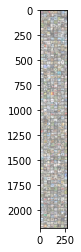

In [ ]:
plot_samples(trainloader)

In [ ]:
model = Model11().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

lr_finder = LRRangeFinder(model, optimizer, criterion, device=DEVICE)
lr_finder.range_test(trainloader, testloader, end_lr=5, num_iter=300, step_mode="linear")
lr_finder.plot() # to inspect the accuracy-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.11E-01


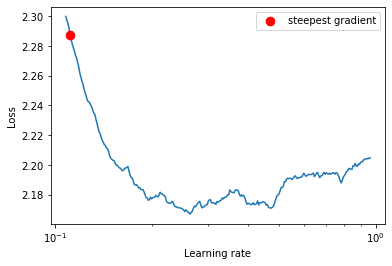

In [ ]:
model = Model11().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9) #lr=1e-7

lr_finder = LRFinder(model, optimizer, criterion, device=DEVICE)
lr_finder.range_test(trainloader, end_lr=1, num_iter=300)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
# Training loop
model = Model11().to(DEVICE)
criterion = nn.CrossEntropyLoss()

lr = 1.11E-01 # Max lr from range test
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)   #1.03E-01      #3.85E-02, 2.18E-02

#scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=.2)
#scheduler = OneCycleLR(optimizer, max_lr=lr, epochs=24, steps_per_epoch=98, pct_start=0.208, anneal_strategy='linear', div_factor=10.0, final_div_factor=1.0)
scheduler = OneCycleLR(optimizer, max_lr=lr, epochs=24, steps_per_epoch=98, pct_start=0.208, anneal_strategy='linear', cycle_momentum=False, div_factor=10.0, final_div_factor=1.0)

train_loss, train_acc = train_onecyclelr(epochs, trainloader, model, DEVICE, optimizer, criterion, scheduler)
#train_loss, train_acc = train_loop_2(epochs, trainloader, model, DEVICE, optimizer, criterion, scheduler, True)

[1,    98] loss: 205.784
LR is:  0.031153009323741952
[2,    98] loss: 190.355
LR is:  0.051206018647483906
[3,    98] loss: 183.017
LR is:  0.07125902797122587
[4,    98] loss: 179.652
LR is:  0.09131203729496781
[5,    98] loss: 177.782
LR is:  0.11090432513914657
[6,    98] loss: 175.376
LR is:  0.10564864332096474
[7,    98] loss: 172.812
LR is:  0.10039296150278293
[8,    98] loss: 170.407
LR is:  0.09513727968460112
[9,    98] loss: 168.519
LR is:  0.08988159786641929
[10,    98] loss: 167.088
LR is:  0.08462591604823748
[11,    98] loss: 165.917
LR is:  0.07937023423005565
[12,    98] loss: 164.056
LR is:  0.07411455241187384
[13,    98] loss: 163.252
LR is:  0.06885887059369201
[14,    98] loss: 162.474
LR is:  0.06360318877551019
[15,    98] loss: 161.147
LR is:  0.058347506957328384
[16,    98] loss: 160.139
LR is:  0.05309182513914657
[17,    98] loss: 160.037
LR is:  0.04783614332096474
[18,    98] loss: 158.824
LR is:  0.042580461502782926
[19,    98] loss: 158.142
LR is: 

In [ ]:
# Test Loop

test_loss, test_acc = test_loop(testloader, model, DEVICE, criterion)
accuracy_per_class(model, classes, testloader, DEVICE)

Accuracy of the network on the 10000 test images: 85 %, Test loss: 336.65800762176514
Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 75 %
Accuracy of   cat : 57 %
Accuracy of  deer : 100 %
Accuracy of   dog : 88 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 88 %
